In [104]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow.keras import layers, regularizers
import random
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import itertools

In [105]:
rootDir = './animals-dataset'
trainingDir = rootDir + '/training'
testDir = rootDir + '/test'

In [106]:
seed = 512
validation_split = 0.2
interpolation = "bilinear"
batch_size = 32
img_height = 256
img_width = 256

In [107]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    trainingDir,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    interpolation=interpolation
)

Found 837 files belonging to 4 classes.
Using 670 files for training.


In [108]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    trainingDir,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    interpolation=interpolation
)

Found 837 files belonging to 4 classes.
Using 167 files for validation.


In [109]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    testDir,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    interpolation=interpolation
)

Found 80 files belonging to 4 classes.


In [110]:
class_names = train_ds.class_names
print(class_names)

['chicken', 'elefant', 'sheep', 'spider']


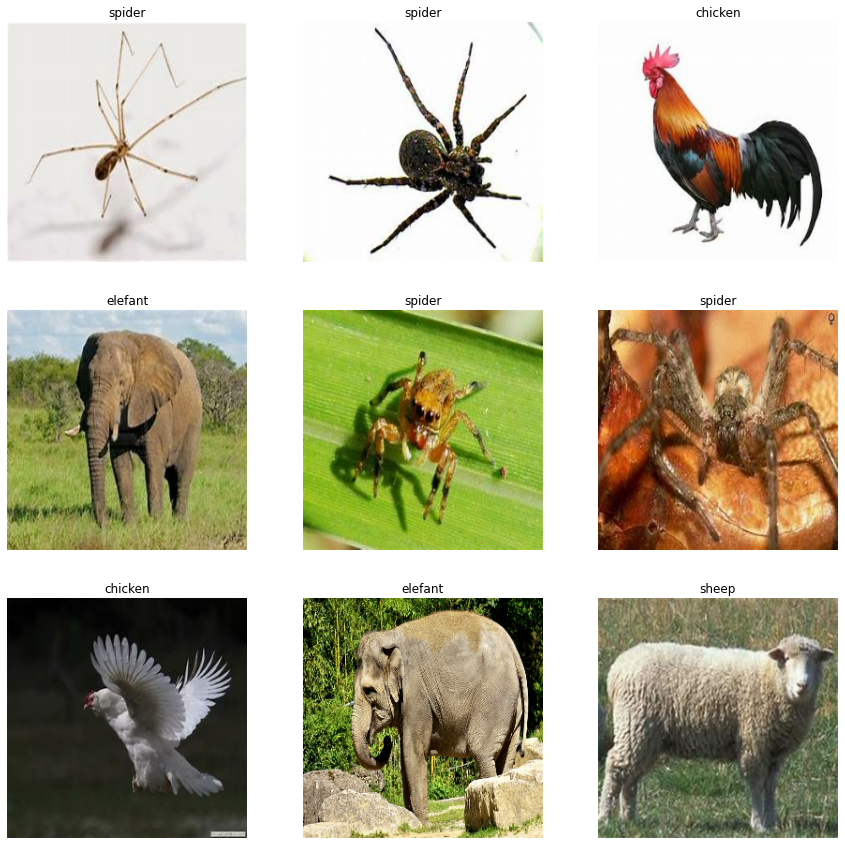

In [111]:
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [112]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [113]:
num_classes = len(class_names)
print(num_classes)
    
model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16, 2, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 2, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 2, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    #layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    #layers.Dropout(0.5),
    #layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    #layers.Dropout(0.5),
    layers.Dense(num_classes)
])

4


In [114]:
model.compile(
  optimizer=tf.optimizers.Adam(learning_rate=0.001),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [115]:
history = model.fit(
    train_ds,
    #steps_per_epoch=100,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
21/21 [==============================] - 7s 350ms/step - loss: 2.2623 - accuracy: 0.3567 - val_loss: 2.0059 - val_accuracy: 0.4132
Epoch 2/10
21/21 [==============================] - 6s 266ms/step - loss: 1.9084 - accuracy: 0.3925 - val_loss: 1.8784 - val_accuracy: 0.4132
Epoch 3/10
21/21 [==============================] - 6s 265ms/step - loss: 1.7966 - accuracy: 0.4209 - val_loss: 1.7754 - val_accuracy: 0.4132
Epoch 4/10
21/21 [==============================] - 5s 257ms/step - loss: 1.6941 - accuracy: 0.4313 - val_loss: 1.6833 - val_accuracy: 0.4132
Epoch 5/10
21/21 [==============================] - 6s 264ms/step - loss: 1.5889 - accuracy: 0.4582 - val_loss: 1.5598 - val_accuracy: 0.4311
Epoch 6/10
21/21 [==============================] - 6s 271ms/step - loss: 1.4714 - accuracy: 0.4836 - val_loss: 1.4788 - val_accuracy: 0.5090
Epoch 7/10
21/21 [==============================] - 5s 261ms/step - loss: 1.4097 - accuracy: 0.5299 - val_loss: 1.3784 - val_accuracy: 0.5689
Epoch 

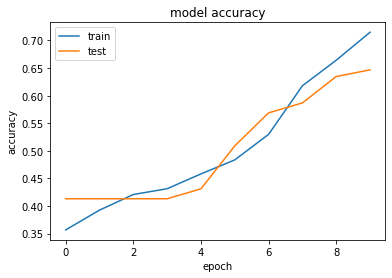

In [116]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

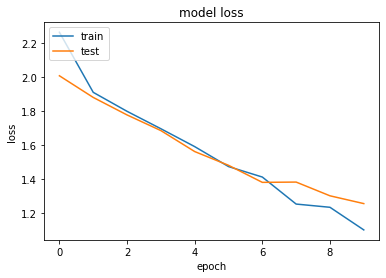

In [117]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [118]:
test_loss, test_acc = model.evaluate(test_ds, verbose=1)

3/3 [==============================] - 0s 36ms/step - loss: 1.5955 - accuracy: 0.5750


In [119]:
print('Test accuracy: ' +  str(test_acc) + " Loss: " + str(test_loss))

Test accuracy: 0.574999988079071 Loss: 1.5955034494400024


In [120]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_ds)

In [121]:
predictions[0]

array([3.4909453e-02, 4.6231938e-04, 9.1918069e-04, 9.6370900e-01],
      dtype=float32)

In [122]:
np.argmax(predictions[0])

3

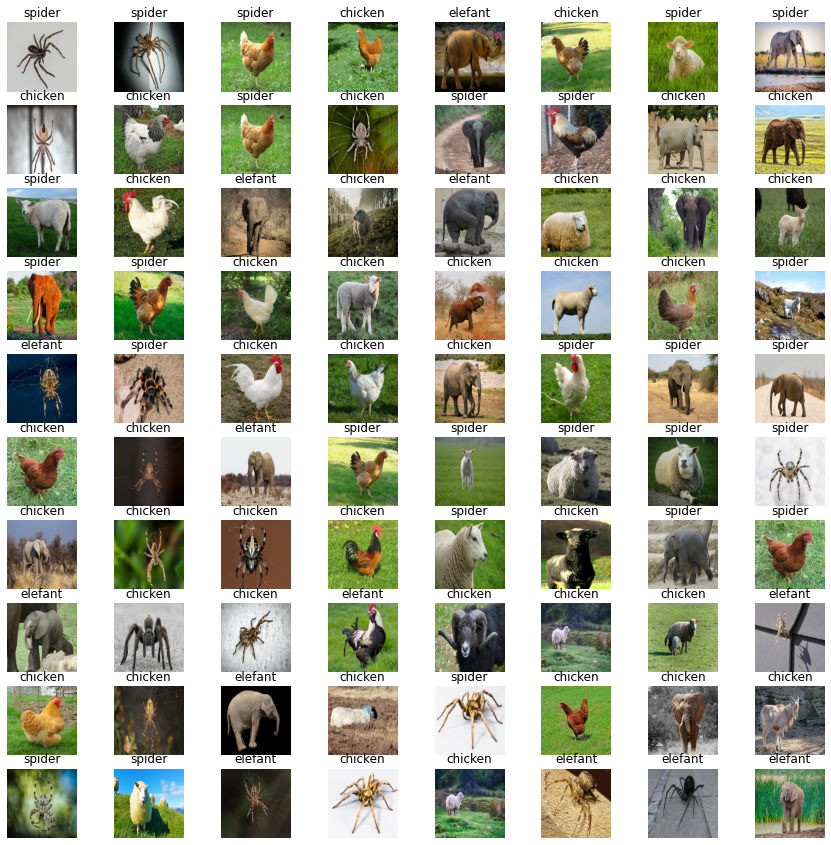

In [135]:
plt.figure(figsize=(15, 15))
test_images = []
for images, labels in test_ds:
    test_images.extend(images)

for i,img in enumerate(test_images):
    ax = plt.subplot(10, 8, i + 1)
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(class_names[np.argmax(predictions[i])])
    plt.axis("off")

In [183]:
prediction_counter = 0
l = []
p = []
for images, labels in test_ds:
    for i in range(len(labels)):
        l.append(labels[i].numpy())
        p.append(np.argmax(predictions[prediction_counter]))
        prediction_counter += 1

In [184]:
cm = tf.math.confusion_matrix(l, p)
cm = cm / len(l)

In [185]:
# https://docs.python.org/3/library/itertools.html#module-itertools
# https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Use white text if squares are dark; otherwise black.
    threshold = np.max(cm) / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j].numpy(), horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #return figure

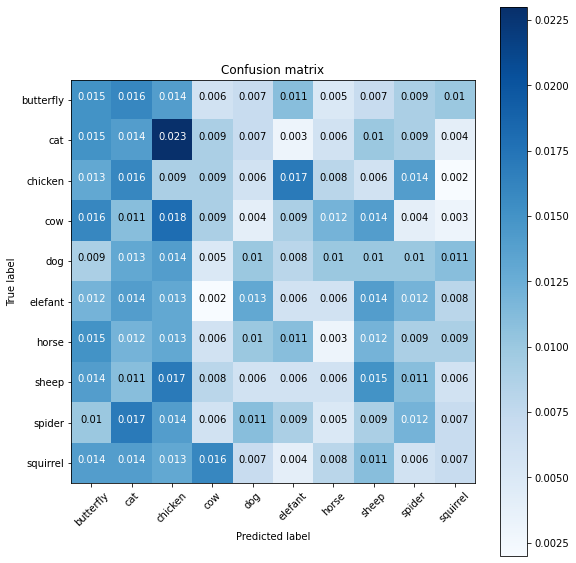

In [186]:
plot_confusion_matrix(cm, class_names)